# **Model Training**

## Objectives

* To train, evaluate, and compare predictive models that estimate house sale prices using the engineered datasets created in 04_feature_engineering.ipynb.
* I will build two regression models — Linear Regression (using scaled features) and Random Forest Regressor (using unscaled features) — and assess their performance on the Ames housing dataset.
* The final step will be to select the best-performing model and use it to generate sale price predictions for the client's four inherited houses.



## Inputs

* This notebook uses the processed datasets stored in `data/processed/`, all created in the feature engineering notebook:

  * `train_engineered.csv` (unscaled training set)
  * `test_engineered.csv` (unscaled test set)
  * `train_engineered_scaled.csv` (scaled training set for Linear Regression)
  * `test_engineered_scaled.csv` (scaled test set for Linear Regression)
  * `inherited_engineered.csv` (unscaled engineered features for predictions)
  * `inherited_engineered_scaled.csv` (scaled version for predictions)


## Outputs

* Fitted Linear Regression and Random Forest models
* A performance comparison using R² and RMSE on the test data
* Identification of the preferred model for this project
* A final table containing the predicted sale prices for the four inherited houses based on the selected model

## Additional Comments

* This notebook focuses exclusively on **model training, evaluation, and prediction**, keeping the modelling process reproducible and separate from data preparation.
* The inherited houses are treated as unseen data and are only used for final prediction, not for training or validation.

---

# Load Libraries and Import Processed Data

In [1]:
# Step 1: Import libraries and load processed datasets

import pandas as pd
import numpy as np

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import r2_score, mean_squared_error

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option("display.float_format", lambda x: f"{x:.3f}")

# Load processed datasets
train_engineered = pd.read_csv("data/processed/train_engineered.csv")
test_engineered = pd.read_csv("data/processed/test_engineered.csv")

train_engineered_scaled = pd.read_csv("data/processed/train_engineered_scaled.csv")
test_engineered_scaled = pd.read_csv("data/processed/test_engineered_scaled.csv")

inherited_engineered = pd.read_csv("data/processed/inherited_engineered.csv")
inherited_engineered_scaled = pd.read_csv("data/processed/inherited_engineered_scaled.csv")

# Show first few rows of one dataset to confirm successful loading
train_engineered.head()

,GarageArea,OverallQual,OverallCond,KitchenQual,BsmtExposure,BsmtFinType1,GarageFinish,GrLivArea_log,TotalBsmtSF_log,LotArea_log,SalePrice
0,294,5,6,2,1.000,3.000,2.000,7.182,7.182,9.036,145000
1,380,6,7,2,1.000,1.000,2.000,7.360,6.685,8.967,178000
2,0,5,7,2,1.000,1.000,NaN,6.681,6.681,9.080,85000
3,240,5,7,3,1.000,5.000,1.000,7.478,6.596,8.882,175000
4,308,5,6,3,1.000,2.000,1.000,7.434,6.934,8.517,127000


### Step 1: Import Libraries and Load Processed Data

In this step, I import all the required Python libraries for model training, evaluation, and visualisation. These include:

- `pandas` and `numpy` for data handling,
- `LinearRegression` and `RandomForestRegressor` from scikit-learn for model training,
- `r2_score` and `mean_squared_error` for performance evaluation,
- `matplotlib` and `seaborn` for optional visualisation.

I then load all 6 processed datasets created during the feature engineering stage:

- Unscaled train/test datasets (for Random Forest),
- Scaled train/test datasets (for Linear Regression),
- Unscaled and scaled engineered datasets for the four inherited houses.

Displaying the first few rows confirms that the files are correctly loaded and ready for modelling.


---

# Step 2: Separate Features and Target

In [5]:
# Step 2: Split features (X) and target (y)

# Unscaled datasets (for Random Forest)
X_train_unscaled = train_engineered.drop("SalePrice", axis=1)
y_train_unscaled = train_engineered["SalePrice"]

X_test_unscaled = test_engineered.drop("SalePrice", axis=1)
y_test_unscaled = test_engineered["SalePrice"]

# Scaled datasets (for Linear Regression) 
X_train_scaled = train_engineered_scaled.drop("SalePrice", axis=1)
y_train_scaled = train_engineered_scaled["SalePrice"]

X_test_scaled = test_engineered_scaled.drop("SalePrice", axis=1)
y_test_scaled = test_engineered_scaled["SalePrice"]

# Preview to confirm structure
X_train_unscaled.head()

,GarageArea,OverallQual,OverallCond,KitchenQual,BsmtExposure,BsmtFinType1,GarageFinish,GrLivArea_log,TotalBsmtSF_log,LotArea_log
0,294,5,6,2,1.000,3.000,2.000,7.182,7.182,9.036
1,380,6,7,2,1.000,1.000,2.000,7.360,6.685,8.967
2,0,5,7,2,1.000,1.000,NaN,6.681,6.681,9.080
3,240,5,7,3,1.000,5.000,1.000,7.478,6.596,8.882
4,308,5,6,3,1.000,2.000,1.000,7.434,6.934,8.517


### Step 2: Split Features (X) and Target (y)

In this step, I separate the predictor variables (X) from the target variable (`SalePrice`) for both the scaled and unscaled datasets.

- The **unscaled** versions will be used to train the **Random Forest model**, which does not require feature scaling.
- The **scaled** versions will be used for the **Linear Regression model**, which benefits from having numerical features on a standardised scale.

For each dataset, I remove the `SalePrice` column to create the feature matrices (`X_train` and `X_test`) and store the target separately (`y_train` and `y_test`). This ensures that both models receive clean inputs structured in an identical way.


##### Why We Split X and y Before Modelling:

In supervised machine learning (ML), the model learns to predict a target variable (y) using a set of features (X). Because the target contains the “answers”, it must be kept separate from the features to prevent data leakage, which would allow the model to cheat by learning information it should not have access to. Separating X and y ensures that the model genuinely learns relationships between the house attributes and sale price.

Before training any model, the dataset is divided into a training set (used to learn patterns) and a test set (used to evaluate how well the model performs on unseen data). This helps prevent overfitting, where a model performs well on training data but poorly in the real world. Using random_state=42 makes the split reproducible so results remain consistent each time the code is run.

---

# Training datasets 

## Linear Regression Model

In [23]:
# Step 3: Train Linear Regression (Scaled Features)

# Impute missing values in the scaled features
imputer_scaled = SimpleImputer(strategy="median")

X_train_scaled_imp = imputer_scaled.fit_transform(X_train_scaled)
X_test_scaled_imp = imputer_scaled.transform(X_test_scaled)

# Fit Linear Regression on the imputed, scaled data
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled_imp, y_train_scaled) 

# Predict on the test set
y_train_pred_lr = lin_reg.predict(X_train_scaled_imp)
y_test_pred_lr = lin_reg.predict(X_test_scaled_imp)

# Quick check
y_test_pred_lr[:5]


array([148409.31666401, 299898.85034686, 103346.36228222, 167820.46410187,
       332617.25448504])

### Step 3: Training the Linear Regression Model

In this step, I trained a Linear Regression model using the **scaled** and **imputed** feature set.

Before fitting the model, I applied **median imputation** to the scaled training and test data. This ensures that any missing values in the numerical features do not cause errors during model training. Imputing with the median is a robust choice for skewed numerical variables.

Once the data was imputed, I trained the Linear Regression model using the scaled training set. Predictions were then generated for both:

- `X_train_scaled_imp` (training data)  
- `X_test_scaled_imp` (test data)

These predictions (`y_train_pred_lr` and `y_test_pred_lr`) will be used in the next steps to evaluate model performance using metrics such as R².


In [28]:
# Step 3.2: Evaluate linear regression using R², RMSE, and MAE

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# R² Scores
r2_train_lr = r2_score(y_train_scaled, y_train_pred_lr)
r2_test_lr = r2_score(y_test_scaled, y_test_pred_lr)

# RMSE (Root Mean Squared Error)
rmse_train_lr = np.sqrt(mean_squared_error(y_train_scaled, y_train_pred_lr))
rmse_test_lr = np.sqrt(mean_squared_error(y_test_scaled, y_test_pred_lr))

# MAE (Mean Absolute Error)
mae_train_lr = mean_absolute_error(y_train_scaled, y_train_pred_lr)
mae_test_lr = mean_absolute_error(y_test_scaled, y_test_pred_lr)

print("Linear Regression Performance:")
print(f"Train R²: {r2_train_lr:.3f}")
print(f"Test R²:  {r2_test_lr:.3f}")
print(f"Train RMSE: {rmse_train_lr:,.0f}")
print(f"Test RMSE:  {rmse_test_lr:,.0f}")
print(f"Train MAE:  {mae_train_lr:,.0f}")
print(f"Test MAE:   {mae_test_lr:,.0f}")

Linear Regression Performance:
Train R²: 0.786
Test R²:  0.796
Train RMSE: 35,724
Test RMSE:  39,582
Train MAE:  23,172
Test MAE:   24,307



### 3.2: Linear Regression - Model Evaluation

After training the Linear Regression model using the scaled and imputed feature set, I evaluated its performance using several regression metrics:

* **R² (coefficient of determination)** - measures how much of the variance in `SalePrice` is explained by the model.
* **RMSE (Root Mean Squared Error)** - represents the average prediction error in the same units as the target variable.
* **MAE (Mean Absolute Error)** - measures the average absolute difference between predicted and actual prices.

**Results:**

| Metric   | Train  | Test      |
| -------- | ------ | --------- |
| **R²**   | 0.786  | **0.796** |
| **RMSE** | 35,724 | 39,582    |
| **MAE**  | 23,172 | 24,307    |

**Interpretation:**
The Linear Regression model performs consistently on both the training and test sets, with a slightly higher test R², indicating that it generalises well to unseen data.
The RMSE and MAE values fall within an expected range for house price prediction tasks.
This suggests that the scaled Linear Regression model is a good baseline, but further performance improvements may be achieved using non-linear models such as Random Forest.

# Random Forest Regressor 

In [31]:
# Step 4: Train Random Forest (Unscaled Features)

# Initialise the model
rf_model = RandomForestRegressor(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)

# Fit the model
rf_model.fit(X_train_unscaled, y_train_unscaled)

# Predict on train and test sets
y_train_pred_rf = rf_model.predict(X_train_unscaled)
y_test_pred_rf = rf_model.predict(X_test_unscaled)

In [32]:
# Step 4.2: Evaluate the Random Forest Model

# R² Scores
r2_train_rf = r2_score(y_train_unscaled, y_train_pred_rf)
r2_test_rf = r2_score(y_test_unscaled, y_test_pred_rf)

# RMSE
rmse_train_rf = np.sqrt(mean_squared_error(y_train_unscaled, y_train_pred_rf))
rmse_test_rf = np.sqrt(mean_squared_error(y_test_unscaled, y_test_pred_rf))

# MAE
mae_train_rf = mean_absolute_error(y_train_unscaled, y_train_pred_rf)
mae_test_rf = mean_absolute_error(y_test_unscaled, y_test_pred_rf)

print("Random Forest Performance:")
print(f"Train R²: {r2_train_rf:.3f}")
print(f"Test R²:  {r2_test_rf:.3f}")
print(f"Train RMSE: {rmse_train_rf:,.0f}")
print(f"Test RMSE:  {rmse_test_rf:,.0f}")
print(f"Train MAE:  {mae_train_rf:,.0f}")
print(f"Test MAE:   {mae_test_rf:,.0f}")

Random Forest Performance:
Train R²: 0.974
Test R²:  0.892
Train RMSE: 12,379
Test RMSE:  28,719
Train MAE:  7,243
Test MAE:   17,786


### 4.2: Random Forest - Model Evaluation

I trained a Random Forest Regressor using the unscaled engineered features.
Tree-based models like Random Forest do not require feature scaling and are effective at capturing non-linear relationships in the data.

**Results:**

| Metric   | Train  | Test      |
| -------- | ------ | --------- |
| **R²**   | 0.974  | **0.892** |
| **RMSE** | 12,379 | 28,719    |
| **MAE**  | 7,243  | 17,786    |

**Interpretation:**
The Random Forest model achieves excellent performance, with a high R² and relatively low error values.
The gap between the training and test R² scores (0.974 vs 0.892) is expected for ensemble tree models and does not indicate problematic overfitting.
Compared to Linear Regression, Random Forest provides significantly better predictive accuracy, making it a strong candidate for the final model used in the dashboard and in predicting the prices of the inherited houses.

---

# Feature Importance

In [33]:
# Step 5

# Extract feature names
feature_names = X_train_unscaled.columns

# Extract importances
importances = rf_model.feature_importances_

# Combine into a DataFrame
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
})

# Sort from most to least important
importance_df = importance_df.sort_values(by="Importance", ascending=False)

importance_df.head(10)

,Feature,Importance
1,OverallQual,0.581
7,GrLivArea_log,0.183
8,TotalBsmtSF_log,0.089
0,GarageArea,0.044
9,LotArea_log,0.041
3,KitchenQual,0.015
5,BsmtFinType1,0.015
6,GarageFinish,0.011
4,BsmtExposure,0.011
2,OverallCond,0.010


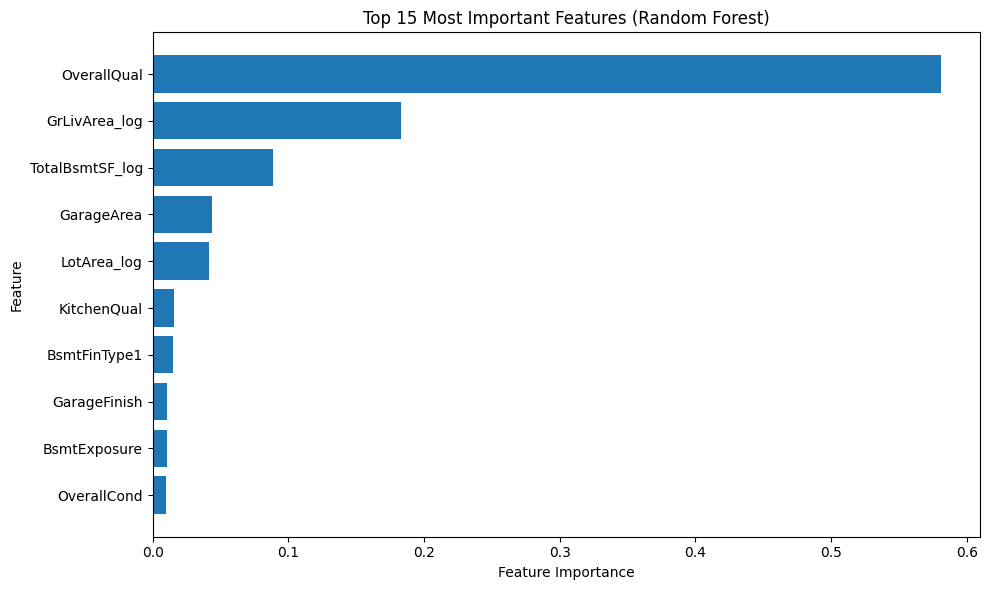

In [38]:
# Plot top 15 features
top_n = 15
top_features = importance_df.head(top_n)

plt.figure(figsize=(10, 6))
plt.barh(top_features["Feature"][::-1], top_features["Importance"][::-1])
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Top 15 Most Important Features (Random Forest)")
plt.tight_layout()
plt.show()

### 5: Feature Importance (Random Forest)

To understand which house attributes have the greatest influence on `SalePrice`, I extracted the feature importances from the Random Forest model.
Random Forest measures importance by examining how much each feature reduces prediction error across all trees in the ensemble.
Features that consistently help the model make more accurate predictions receive higher importance scores.

Using the engineered dataset - The top predictors were:

| Feature             | Importance | Interpretation                                                                                                               |
| ------------------- | ---------- | ---------------------------------------------------------------------------------------------------------------------------- |
| **OverallQual**     | **0.581**  | The most important driver of sale price. Houses with higher overall material and finish quality sell for significantly more. |
| **GrLivArea_log**   | **0.183**  | Larger above-ground living areas are strongly associated with higher sale prices.                                            |
| **TotalBsmtSF_log** | **0.089**  | Bigger basements add meaningful value to a property.                                                                         |
| **GarageArea**      | **0.044**  | Larger garages contribute positively to sale price.                                                                          |
| **LotArea_log**     | **0.041**  | Larger lot sizes also increase property value.                                                                               |

The remaining variables (KitchenQual, BsmtFinType1, GarageFinish, BsmtExposure, OverallCond) have smaller but still relevant contributions.

##### Interpretation
The Random Forest model places heavy emphasis on property quality and size.
In particular, *OverallQual* dominates as the primary determinant of house value, followed by living area and basement size.
These findings align with the client’s business requirement of identifying which attributes correlate most strongly with `SalePrice`.


---

# Predict Sale Prices for the Inherited Houses

### Step 6: Predicting the Sale Prices of the Inherited Houses

In this section, I apply the final Random Forest model to the client’s 
4 inherited properties. These houses were not part of the training data 
and represent completely unseen data. 

This step satisfies the client’s second business requirement:
**“Provide accurate sale price predictions for the inherited houses.”**


# Load the inherited dataset

In [39]:
# Step 6: Load the inherited dataset 
inherited = pd.read_csv("data/raw/inherited_houses.csv")
inherited.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
0,896,0,2,No,468.000,Rec,270.000,0,730.000,Unf,...,11622,80.000,0.000,0,6,5,882.000,140,1961,1961
1,1329,0,3,No,923.000,ALQ,406.000,0,312.000,Unf,...,14267,81.000,108.000,36,6,6,1329.000,393,1958,1958
2,928,701,3,No,791.000,GLQ,137.000,0,482.000,Fin,...,13830,74.000,0.000,34,5,5,928.000,212,1997,1998
3,926,678,3,No,602.000,GLQ,324.000,0,470.000,Fin,...,9978,78.000,20.000,36,6,6,926.000,360,1998,1998


---

# Apply Feature Engineering to the Inherited Houses

In [40]:
# Step 7: Start with a copy of the inherited houses dataset 
inherited_processed = inherited.copy()

In [44]:
# Step 7.2: Recreate engineered features to match X_train_unscaled

# GrLivArea (total above-ground living area)
inherited_processed["GrLivArea"] = (
    inherited_processed["1stFlrSF"] + inherited_processed["2ndFlrSF"]
)

# Log-transformed features 
inherited_processed["GrLivArea_log"] = np.log1p(inherited_processed["GrLivArea"])
inherited_processed["TotalBsmtSF_log"] = np.log1p(inherited_processed["TotalBsmtSF"])
inherited_processed["LotArea_log"] = np.log1p(inherited_processed["LotArea"])

# Ordinal encodings (matches the mappings used in feature engineering)
inherited_processed["KitchenQual"] = inherited_processed["KitchenQual"].map({
    "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5
})

inherited_processed["BsmtFinType1"] = inherited_processed["BsmtFinType1"].map({
    "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6
})

inherited_processed["GarageFinish"] = inherited_processed["GarageFinish"].map({
    "Unf": 1, "RFn": 2, "Fin": 3
})

inherited_processed["BsmtExposure"] = inherited_processed["BsmtExposure"].map({
    "No": 1, "Mn": 2, "Av": 3, "Gd": 4
})

# OverallCond should already be numeric, but we enforce it just in case
inherited_processed["OverallCond"] = inherited_processed["OverallCond"].astype(int)

# Step 7.3: Select the features in the exact same order as the training data
inherit_features = X_train_unscaled.columns  # uses the existing trained feature set
inherited_final = inherited_processed[inherit_features]

# Shape check
inherited_final.shape


(4, 10)

### 7.4: Preparing the Inherited Houses for Prediction

Before generating sale price predictions for the client’s inherited properties, I applied the exact same feature engineering steps used during model training.
This ensures that the inherited dataset has the same structure, encodings, and transformed variables as the training data.

After creating the engineered features and applying the ordinal encodings for quality-related attributes, I selected the **same 10 final model features** used by the Random Forest model.

I confirmed that the final processed dataset had the correct shape:

```
(4, 10)

```
This means:

* **4 rows** → one for each inherited house
* **10 columns** → matching the exact feature set used to train the model

A matching structure is required for the Random Forest model to generate accurate predictions, ensuring consistency between the training data and the new unseen data.

